# Lagrangian patch example

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import scienceplots

import csiborgtools


%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)
bounds = {"dist": (0, 155)}

nsim0 = 7444 + 24 * 61
nsnap_final = paths.get_snapshots(nsim0, "csiborg1")[-1]
snap0_initial = csiborgtools.read.CSiBORG1Snapshot(nsim0, nsnap=1)
cat0 = csiborgtools.read.CSiBORG1Catalogue(nsim0, paths, snapshot=snap0_initial, bounds=bounds)

nsimx = 9844
nsnap_final = paths.get_snapshots(nsimx, "csiborg1")[-1]
snapx_initial = csiborgtools.read.CSiBORG1Snapshot(nsimx, nsnap=1)
catx = csiborgtools.read.CSiBORG1Catalogue(nsimx, paths, snapshot=snapx_initial, bounds=bounds)

pair_overlapper = csiborgtools.summary.PairOverlap(cat0, catx, 13.25, )


In [3]:
k = np.argsort(cat0["totmass"])[::-1][1]

print(np.log10(cat0["totmass"][k]))
print(cat0["dist"][k])

hid0 = cat0["index"][k]


15.319891
74.15419337073868


In [4]:
print("Overlaps are ", pair_overlapper.overlap(True)[k])
hidx = catx["index"][pair_overlapper["match_indxs"][k][0]]

Overlaps are  [7.8512335e-01 9.1506150e-03 2.9659141e-03 3.0178351e-03 2.0852157e-04]


In [5]:
overlapper = csiborgtools.match.ParticleOverlap(**{"box_size": 2048, "bckg_halfsize": 512})

pos0_initial = snap0_initial.halo_coordinates(hid0)
pos0_initial = csiborgtools.match.pos2cell(pos0_initial / cat0.boxsize, 2048)
mass0_initial = snap0_initial.halo_masses(hid0)


posx_initial = snapx_initial.halo_coordinates(hidx)
posx_initial = csiborgtools.match.pos2cell(posx_initial / catx.boxsize, 2048)
massx_initial = snapx_initial.halo_masses(hidx)


In [6]:
smooth_kwargs = {"sigma": 1, "mode": "constant", "cval": 0}
# smooth_kwargs = None

delta1_initial, delta2_initial, cellmins, __ = overlapper.make_deltas(
    pos0_initial, posx_initial, mass0_initial, massx_initial, smooth_kwargs=smooth_kwargs, )

x0 = cellmins[0] / 2048 * 677.7
xf = (cellmins[0] + delta1_initial.shape[0]) / 2048 * 677.7

y0 = cellmins[1] / 2048 * 677.7
yf = (cellmins[1] + delta1_initial.shape[1]) / 2048 * 677.7

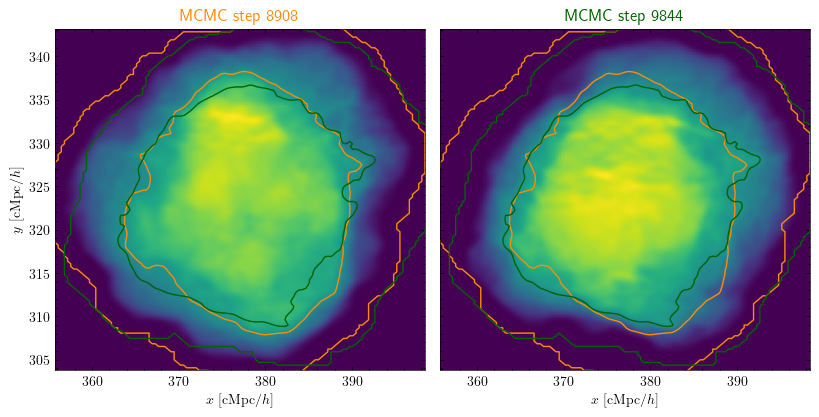

In [56]:
with plt.style.context("science"):
    # plt.rcParams.update({'font.size': 9})

    fig, axs = plt.subplots(1, 2, figsize=(8.3, 0.6* 8.3), sharey=True, sharex=True)
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

    kwargs = {"origin": "lower", "cmap": "viridis", "vmin": 0,
              "extent": [x0, xf, y0, yf]}
    
    X1 = np.mean(delta1_initial, axis=-1)
    X2 = np.mean(delta2_initial, axis=-1)

    img1 = axs[0].imshow(X1, **kwargs)
    img2 = axs[1].imshow(X2, **kwargs)

    kwargs = {"extent": [x0, xf, y0, yf]}
    # contour_level_X1 = np.percentile(X1, [1, 99])  # This will give the value at the 95th percentile
    # # contour_level_X2 = np.percentile(X2, [1, 99])  # You can adjust this to enclose more/less area
    contour_level_X1 = 1
    contour_level_X2 = 1

    axs[0].contour(X1, colors='darkorange', levels=contour_level_X1, **kwargs)
    axs[0].contour(X2, colors='darkgreen', levels=contour_level_X2, **kwargs)

    axs[1].contour(X1, colors='darkorange', levels=contour_level_X1, **kwargs)
    axs[1].contour(X2, colors='darkgreen', levels=contour_level_X2, **kwargs)

    for i in range(2):
        axs[i].set_xlabel(r"$x ~ [\mathrm{cMpc} / h]$")
    axs[0].set_ylabel(r"$y ~ [\mathrm{cMpc} / h]$")

    axs[0].set_title(f"MCMC step {nsim0}", color="darkorange")
    axs[1].set_title(f"MCMC step {nsimx}", color="darkgreen")

    fig.tight_layout()
    fig.savefig("../../plots/lagrangian_patch_example.pdf", bbox_inches="tight", dpi=450)
    fig.show()